In [1]:
from __future__ import division

In [2]:
%matplotlib inline

#### libraries and functions

https://github.com/juhuntenburg/brainsurfacescripts

In [3]:
import gdist
import numpy as np
import pandas as pd
from pqdict import PQDict
#from mayavi import mlab
import seaborn as sns
from scipy import stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk
from graphs import graph_from_mesh, dijkstra, shortest_path, sorted_path
from plotting import plot_surf_stat_map, plot_surf_label
from jensen_shannon import jensenshannon

/scr/ilz1/cbspython_surf/surfenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

In [5]:
def prob_mass_function(data, bins='auto', range_min=None, range_max=None):
    
    import numpy as np
    
    data = data.flatten()
    
    if range_min is None:
        range_min = np.nanmin(data)
    if range_max is None:
        range_max = np.nanmax(data)
        
    if bins == 'auto':
        bins = data.shape[0]/5
        
    p_mass, x_values = np.histogram(data, bins=bins, range=(range_min, range_max))
    p_mass = p_mass / data.shape[0]
    x_values = x_values[:-1] + (x_values[1] - x_values[0])/2
    
    return p_mass, x_values




def jensenshannon(data, range_min=None, range_max=None, base=2, weights=None):
    
    import numpy as np
    import scipy as sp
    
    if range_min is None:
        data_mins = [np.nanmin(m) for m in data]
        range_min = data_mins[np.argmin(data_mins)]
    
    if range_max is None:
        data_maxs = [np.nanmax(n) for n in data]
        range_max = data_maxs[np.argmax(data_maxs)]
    
    data_shapes = [k.shape[0] for k in data]
    bins = int(np.round(data_shapes[np.argmin(data_shapes)]/5))
    p_mass = np.zeros((len(data), bins))
    
    combined_data = []
    for i in range(len(data)):
        p_mass[i], _ = prob_mass_function(data[i], bins, range_min, range_max)
        combined_data += list(data[i])
        
    p_mass_combined, _ = prob_mass_function(np.asarray(combined_data), bins, range_min, range_max)
    
    shannon_entropy = [sp.stats.entropy(p_mass[j], base=base) for j in range(p_mass.shape[0])]
    shared_shannon_entropy = sp.stats.entropy(p_mass_combined, base=base)
    
    if weights is None:
        weights = 1/len(data)
        
    shannon_entropy = np.asarray(shannon_entropy) * np.asarray(weights)
    
    jsdivergence = shared_shannon_entropy - np.sum(shannon_entropy)
    
    jsdistance = np.sqrt(jsdivergence)
    
    return jsdivergence, jsdistance

### Read and convert data

In [6]:
num_path=1

In [7]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy'
embed_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10.npy'
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_rh_profiles.npy'
path_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_path%i.1D.roi'%num_path

#mesh_file = '/SCR/data/ohbm2016/lowres_rh_d.vtk'
#sulc_file = '/SCR/data/ohbm2016/lowres_rh_sulc.npy'
#embed_file = '/SCR/data/ohbm2016/mask_025_5/rh_embed_10.npy'
#t1_file = '/SCR/data/ohbm2016/avg_rh_profiles.npy'

In [8]:
v,f,d=read_vtk(mesh_file)
vertices = v.astype(np.float64)
faces = f.astype(np.int32)
sulc = np.load(sulc_file)
profiles = np.load(t1_file)
embed = np.load(embed_file)
unsorted_path = np.loadtxt(path_file, dtype='int64')[:,0]

In [9]:
G=graph_from_mesh(vertices, faces, edge_length=True)

### Create path and windows

The graph representation of the surface is used to find the shortest path between the chosen source and target node. For each node on the path a window is created containing all other nodes that lie within a given radius and are closer to this node that to any other node on the path. These single node windows are then combined into a larger window with the chosen width that is sliding along the path.

In [10]:
#source=46644
#target=59276
#path=shortest_path(G,source,target)
#path=list(np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_4664_59276.npy'))
#np.save('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_4664_59276.npy', np.asarray(path))
path = sorted_path(G, unsorted_path)

In [11]:
radius=6
halfwidth=2 # combined window size will be 2*halfwidth single windows
overlap=0 # in single windows

In [12]:
# for each vertex show only those vertices in the sparse matrix, that have a distance < radius
# for these give the precise distance
inradius_matrix=gdist.local_gdist_matrix(vertices, faces, max_distance=radius)

In [13]:
# get only the vertices that are in a distance < radius to any node in path
inradius_path=[]
for pnode in path:
    inradius_path=list(np.unique(inradius_matrix[:,path].indices))

In [14]:
# make an array with the radius neighbours in columns and the path nodes in rows
path_x_neighbours=np.zeros((len(inradius_path), len(path)))
for pnode in range(len(path)):
    path_x_neighbours[:,pnode]=np.reshape(inradius_matrix[inradius_path,path[pnode]].toarray(),
                                          (len(inradius_path),))
path_x_neighbours[path_x_neighbours==0]=np.nan

In [15]:
# for each vertex in this list, find the node on path it is closest to
path_x_neighbours_min=np.zeros((len(inradius_path),1))
for nnode in range(len(inradius_path)):
    path_x_neighbours_min[nnode]=np.nanargmin(path_x_neighbours[nnode,:])

In [16]:
#for each node on the path, extract those neighbour nodes, that fall into its window
windows=[]
for pnode in range(len(path)):
    window=[path[pnode]]
    indices = [i for i, x in enumerate(list(path_x_neighbours_min)) if x == pnode]
    [window.append(inradius_path[y]) for y in indices]
    windows.append(window)

In [17]:
# combine single windows for sliding, some nodes at the end of the path might be dropped to ensure equal sized windows
combined_windows=[]
for window in np.arange(start=halfwidth, stop=len(windows)-halfwidth, step=2*halfwidth-overlap):
    combined_window=[]
    for k in range(window-halfwidth,window+halfwidth):
        combined_window+=windows[k]
    combined_windows.append(combined_window)

### Sample profiles in windows

In [18]:
profiles = profiles[:,3:8]

In [19]:
# sample t1 per window, calc mean profile and sdv
profile_windows=[]
profile_avg=[]
profile_sdv=[]
for window in combined_windows:
    profile_windows.append(profiles[window])
    profile_avg.append(np.mean(profiles[window], axis=0))
    profile_sdv.append(np.std(profiles[window], axis=0))

In [20]:
# calculate chebychev coefficients for all the profiles in the windows, as well as mean chebychev per window
cheb_windows=[]
cheb_avg=[]
for window in combined_windows:
    coeff, poly = chebapprox(profiles[window], degree=4)
    cheb_windows.append(coeff)
    cheb_avg.append(np.mean(coeff, axis=0))

In [21]:
# calculate jensen shannon divergence between windows regarding average, profiles, chebychev coefficients
t1_avg_jsdis = np.zeros((len(profile_windows)-1,))
t1_avg_jsdiv = np.zeros((len(profile_windows)-1,))
profile_jsdis = np.zeros((len(profile_windows)-1,profile_windows[0].shape[1]))
cheb_jsdis = np.zeros((len(cheb_windows)-1,cheb_windows[0].shape[1]))
                     
for j in range(len(profile_windows)-1):
    t1_avg_jsdiv[j], t1_avg_jsdis[j] = jensenshannon([np.mean(profile_windows[j], axis=1), 
                                        np.mean(profile_windows[j+1], axis=1)], 
                                       range_min=1500, range_max=2500)
    
    for p in range(profile_windows[j].shape[1]):
        _, profile_jsdis[j][p] = jensenshannon([profile_windows[j][:,p], profile_windows[j+1][:,p]], 
                                               range_min=1500, range_max=2500)
                     
    for c in range(cheb_windows[j].shape[1]):
        _, cheb_jsdis[j][c] = jensenshannon([cheb_windows[j][:,c], cheb_windows[j+1][:,c]])

### Plotting

#### Functional connectivity embedding

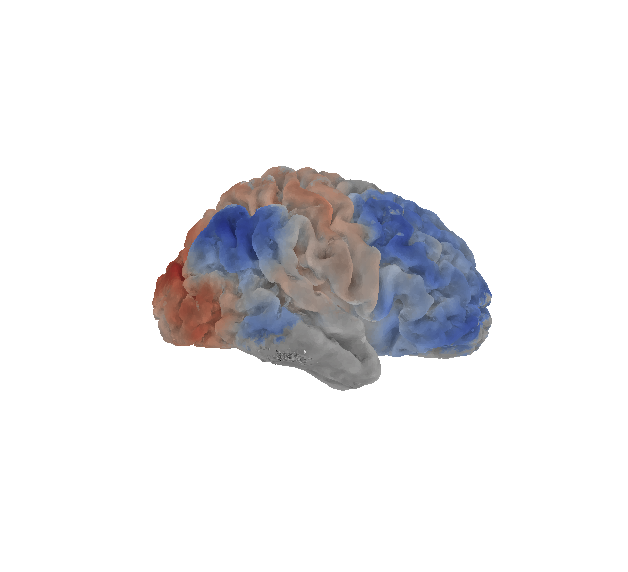

In [22]:
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=embed[:,0],
                        bg_map=sulc, bg_on_stat=True,
                        elev=180, azim=0,
                        #elev=200,azim=20,
                        #cmap='jet',
                        figsize=(11,10))

#### Path

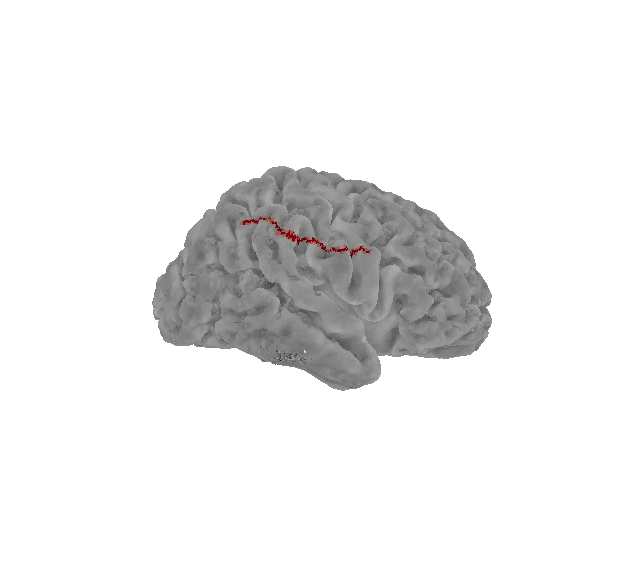

In [23]:
sns.set_style('white')
pathbrain = np.zeros_like(vertices[:,0])
pathbrain[path] = 1
plot=plot_surf_stat_map(vertices, faces, stat_map=pathbrain, bg_map=sulc, bg_on_stat=True, elev=180,azim=0, figsize=(11,10))

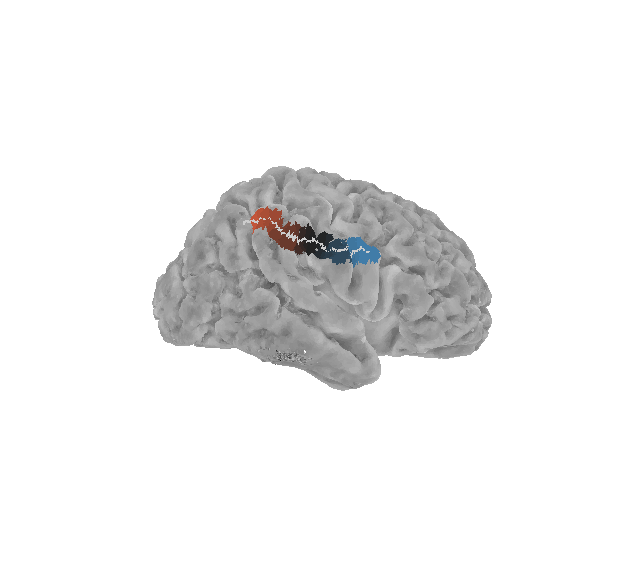

In [27]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(combined_windows+[path]), cpal=eta_cmap[1:]+[eta_cmap[0]], bg_map=sulc, 
                        elev=180,azim=0, figsize=(11,10))

In [28]:
allwindow_surf=np.zeros((len(vertices),))
for window in range(len(windows)):
    allwindow_surf[windows[window]]=window+10

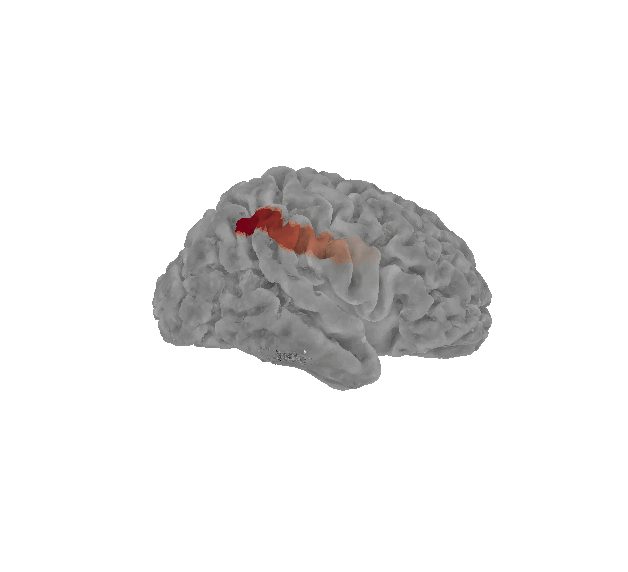

In [29]:
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=allwindow_surf, bg_map=sulc, bg_on_stat=True, 
                        elev=180,azim=0, figsize=(11,10))

In [30]:
window_surfs=[]
for combined_window in range(len(combined_windows)):
    window_surf=np.zeros((len(vertices),))
    for j in path:
        window_surf[j]=-10
    for i in combined_windows[combined_window]:
        window_surf[i]=10
    window_surfs.append(window_surf)

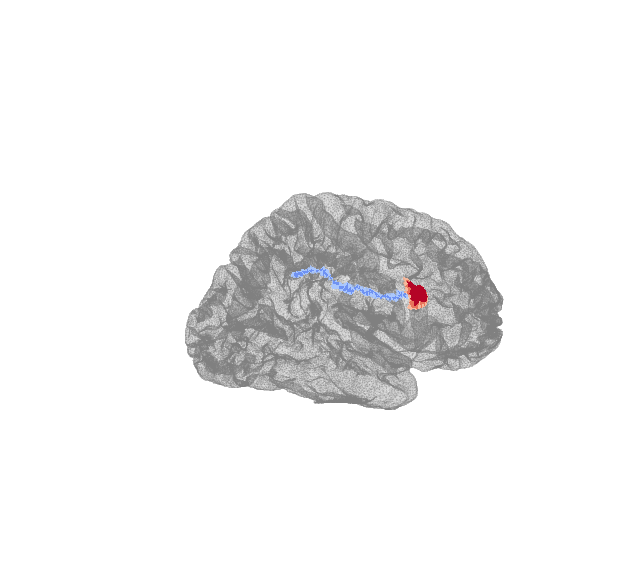

In [31]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[0], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

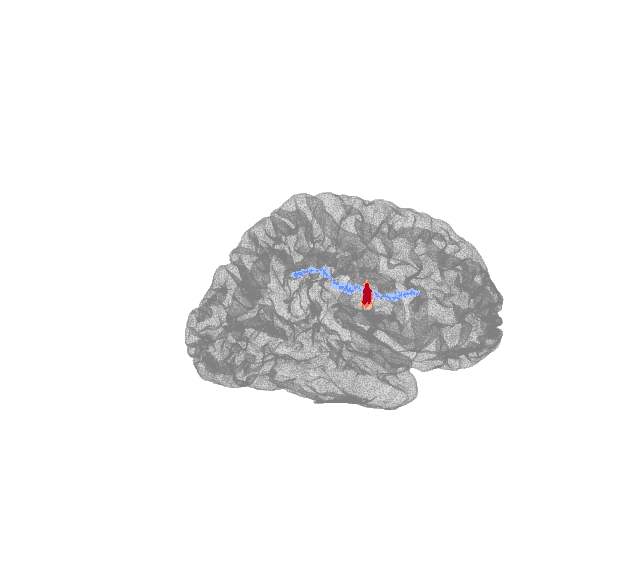

In [32]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[int(len(window_surfs)/2)], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

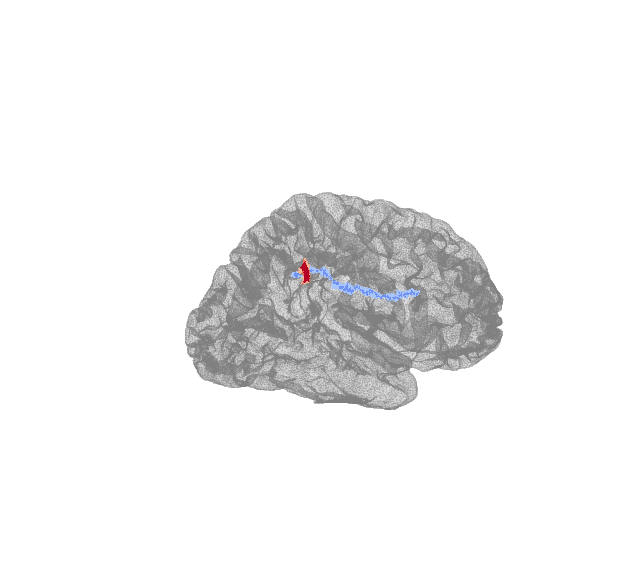

In [33]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[-1], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

#### T1 profiles in windows

In [34]:
sns.set_style('darkgrid')
colors = sns.color_palette('cubehelix', 10)

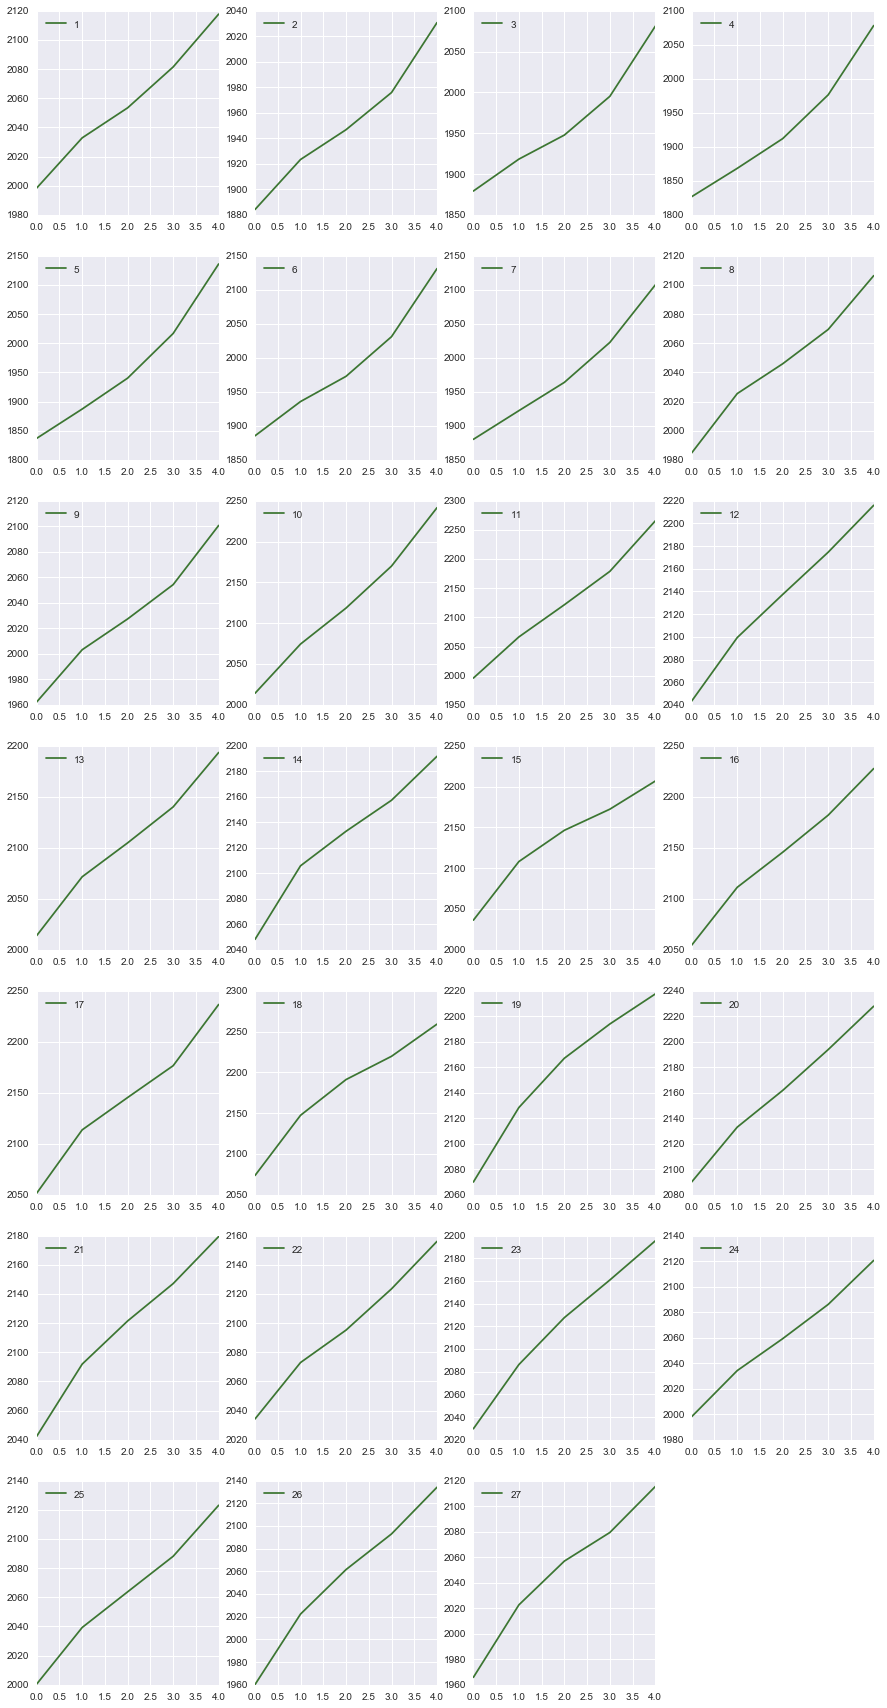

In [35]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    plt.plot(profile_avg[i], label=str(i+1), color=colors[3])
    plt.legend(loc=2)

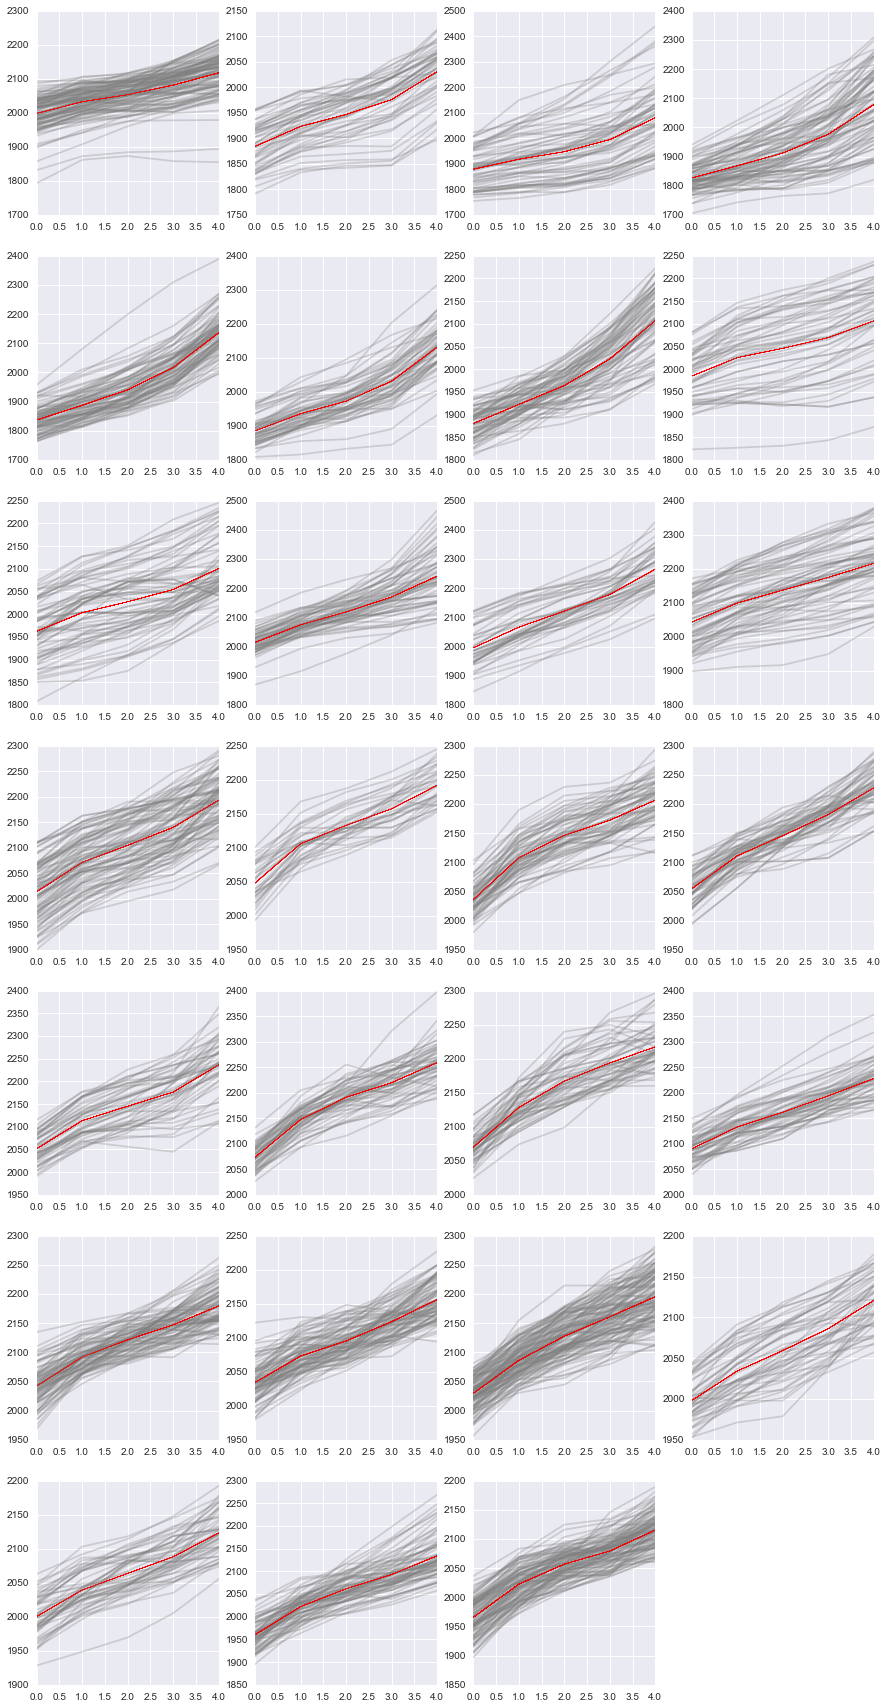

In [36]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    for pro in range(len(profile_windows[i])):
        plt.plot(profile_windows[i][pro],color='gray', alpha=0.3)
        plt.plot(profile_avg[i], color='red', linewidth=0.2)

In [37]:
def make_eta_cmap(c):
    cmap= np.asarray(sns.diverging_palette(240, 20, n=c, center='dark'))
    cmap = np.concatenate((np.array([[0.8,0.8,0.8,1]]), cmap), axis=0)
    #cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

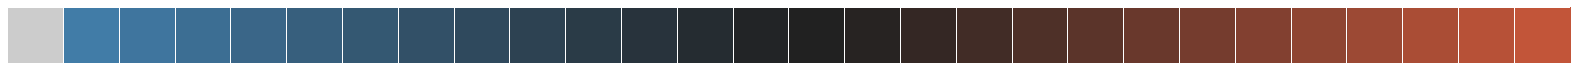

In [38]:
eta_cmap, eta_cmap_255 = make_eta_cmap(len(profile_avg))
sns.palplot(eta_cmap)

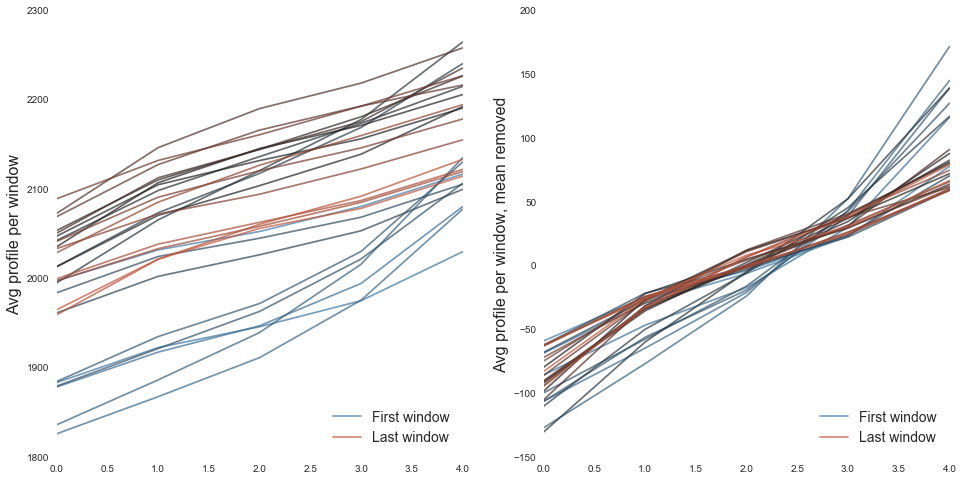

In [39]:
sns.set_style('white')
alpha=0.7
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
for i in range(len(profile_avg)):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(profile_avg[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(profile_avg)-1:
        plt.plot(profile_avg[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(profile_avg[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)
plt.ylabel('Avg profile per window', fontsize=16)


fig.add_subplot(122)
for i in range(len(profile_avg)):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(profile_avg)-1:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)
plt.ylabel('Avg profile per window, mean removed', fontsize=16)

sns.despine(left=True, bottom=True)

#### Chebychev coefficients in windows

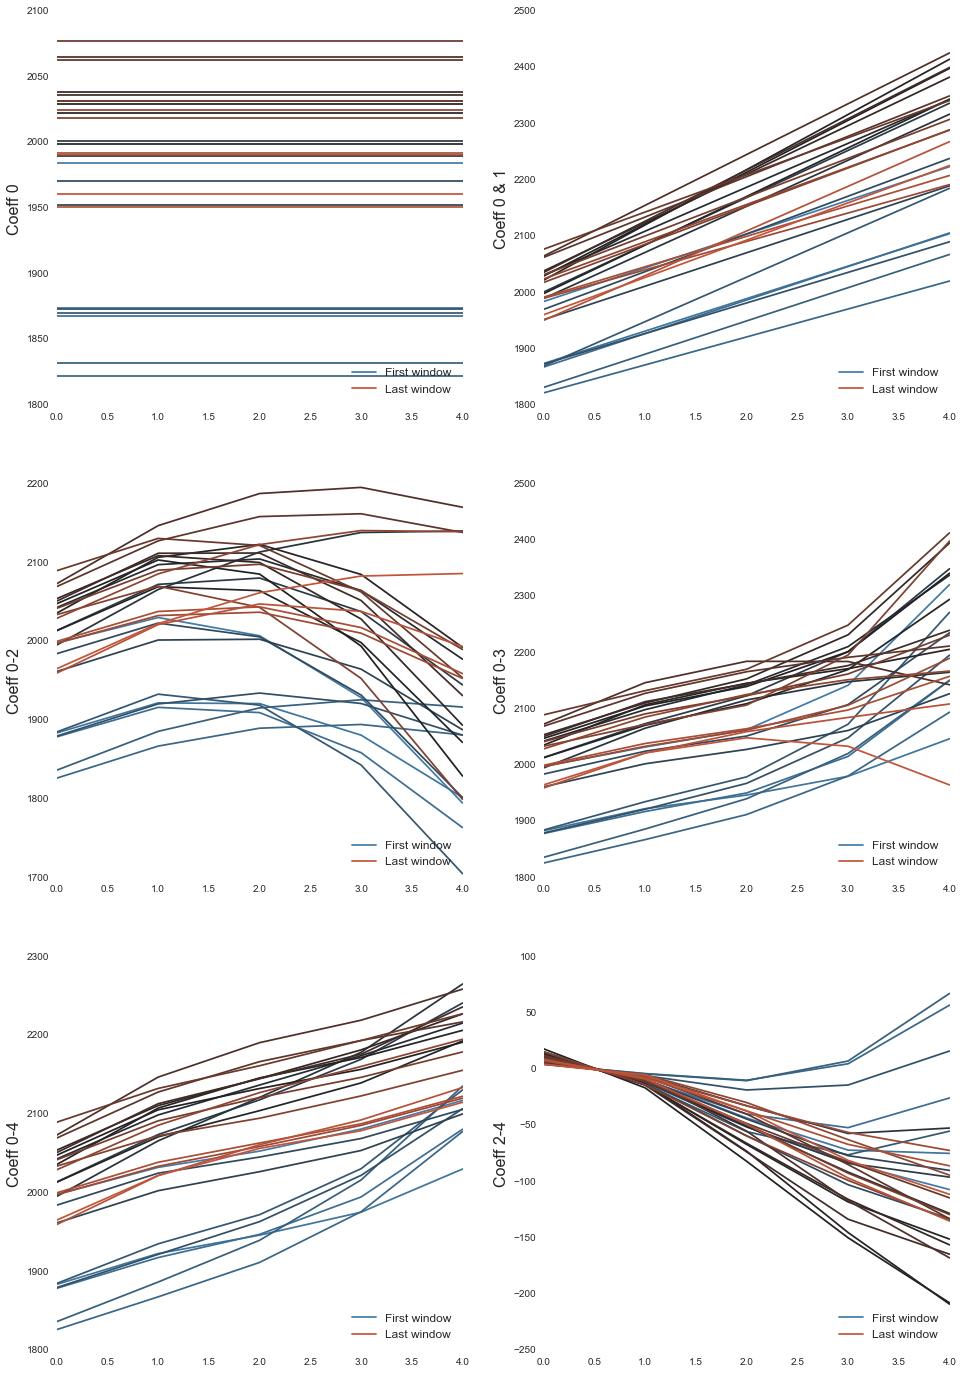

In [40]:
alpha=1
x = np.arange(len(cheb_windows[0][0]))
fig = plt.figure(figsize=(16,24))

fig.add_subplot(321)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0]])
    
for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0', fontsize=16)



fig.add_subplot(322)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],cheb_avg[w][1]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0 & 1', fontsize=16)



fig.add_subplot(323)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],cheb_avg[w][1],cheb_avg[w][2]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0-2', fontsize=16)



fig.add_subplot(324)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],
                                                           cheb_avg[w][1],
                                                           cheb_avg[w][2],
                                                           cheb_avg[w][3]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0-3', fontsize=16)




fig.add_subplot(325)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],cheb_avg[w][1],
                                                            cheb_avg[w][2],cheb_avg[w][3],cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0-4', fontsize=16)



fig.add_subplot(326)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,cheb_avg[w][2],cheb_avg[w][3],cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 2-4', fontsize=16)

sns.despine(left=True, bottom=True)

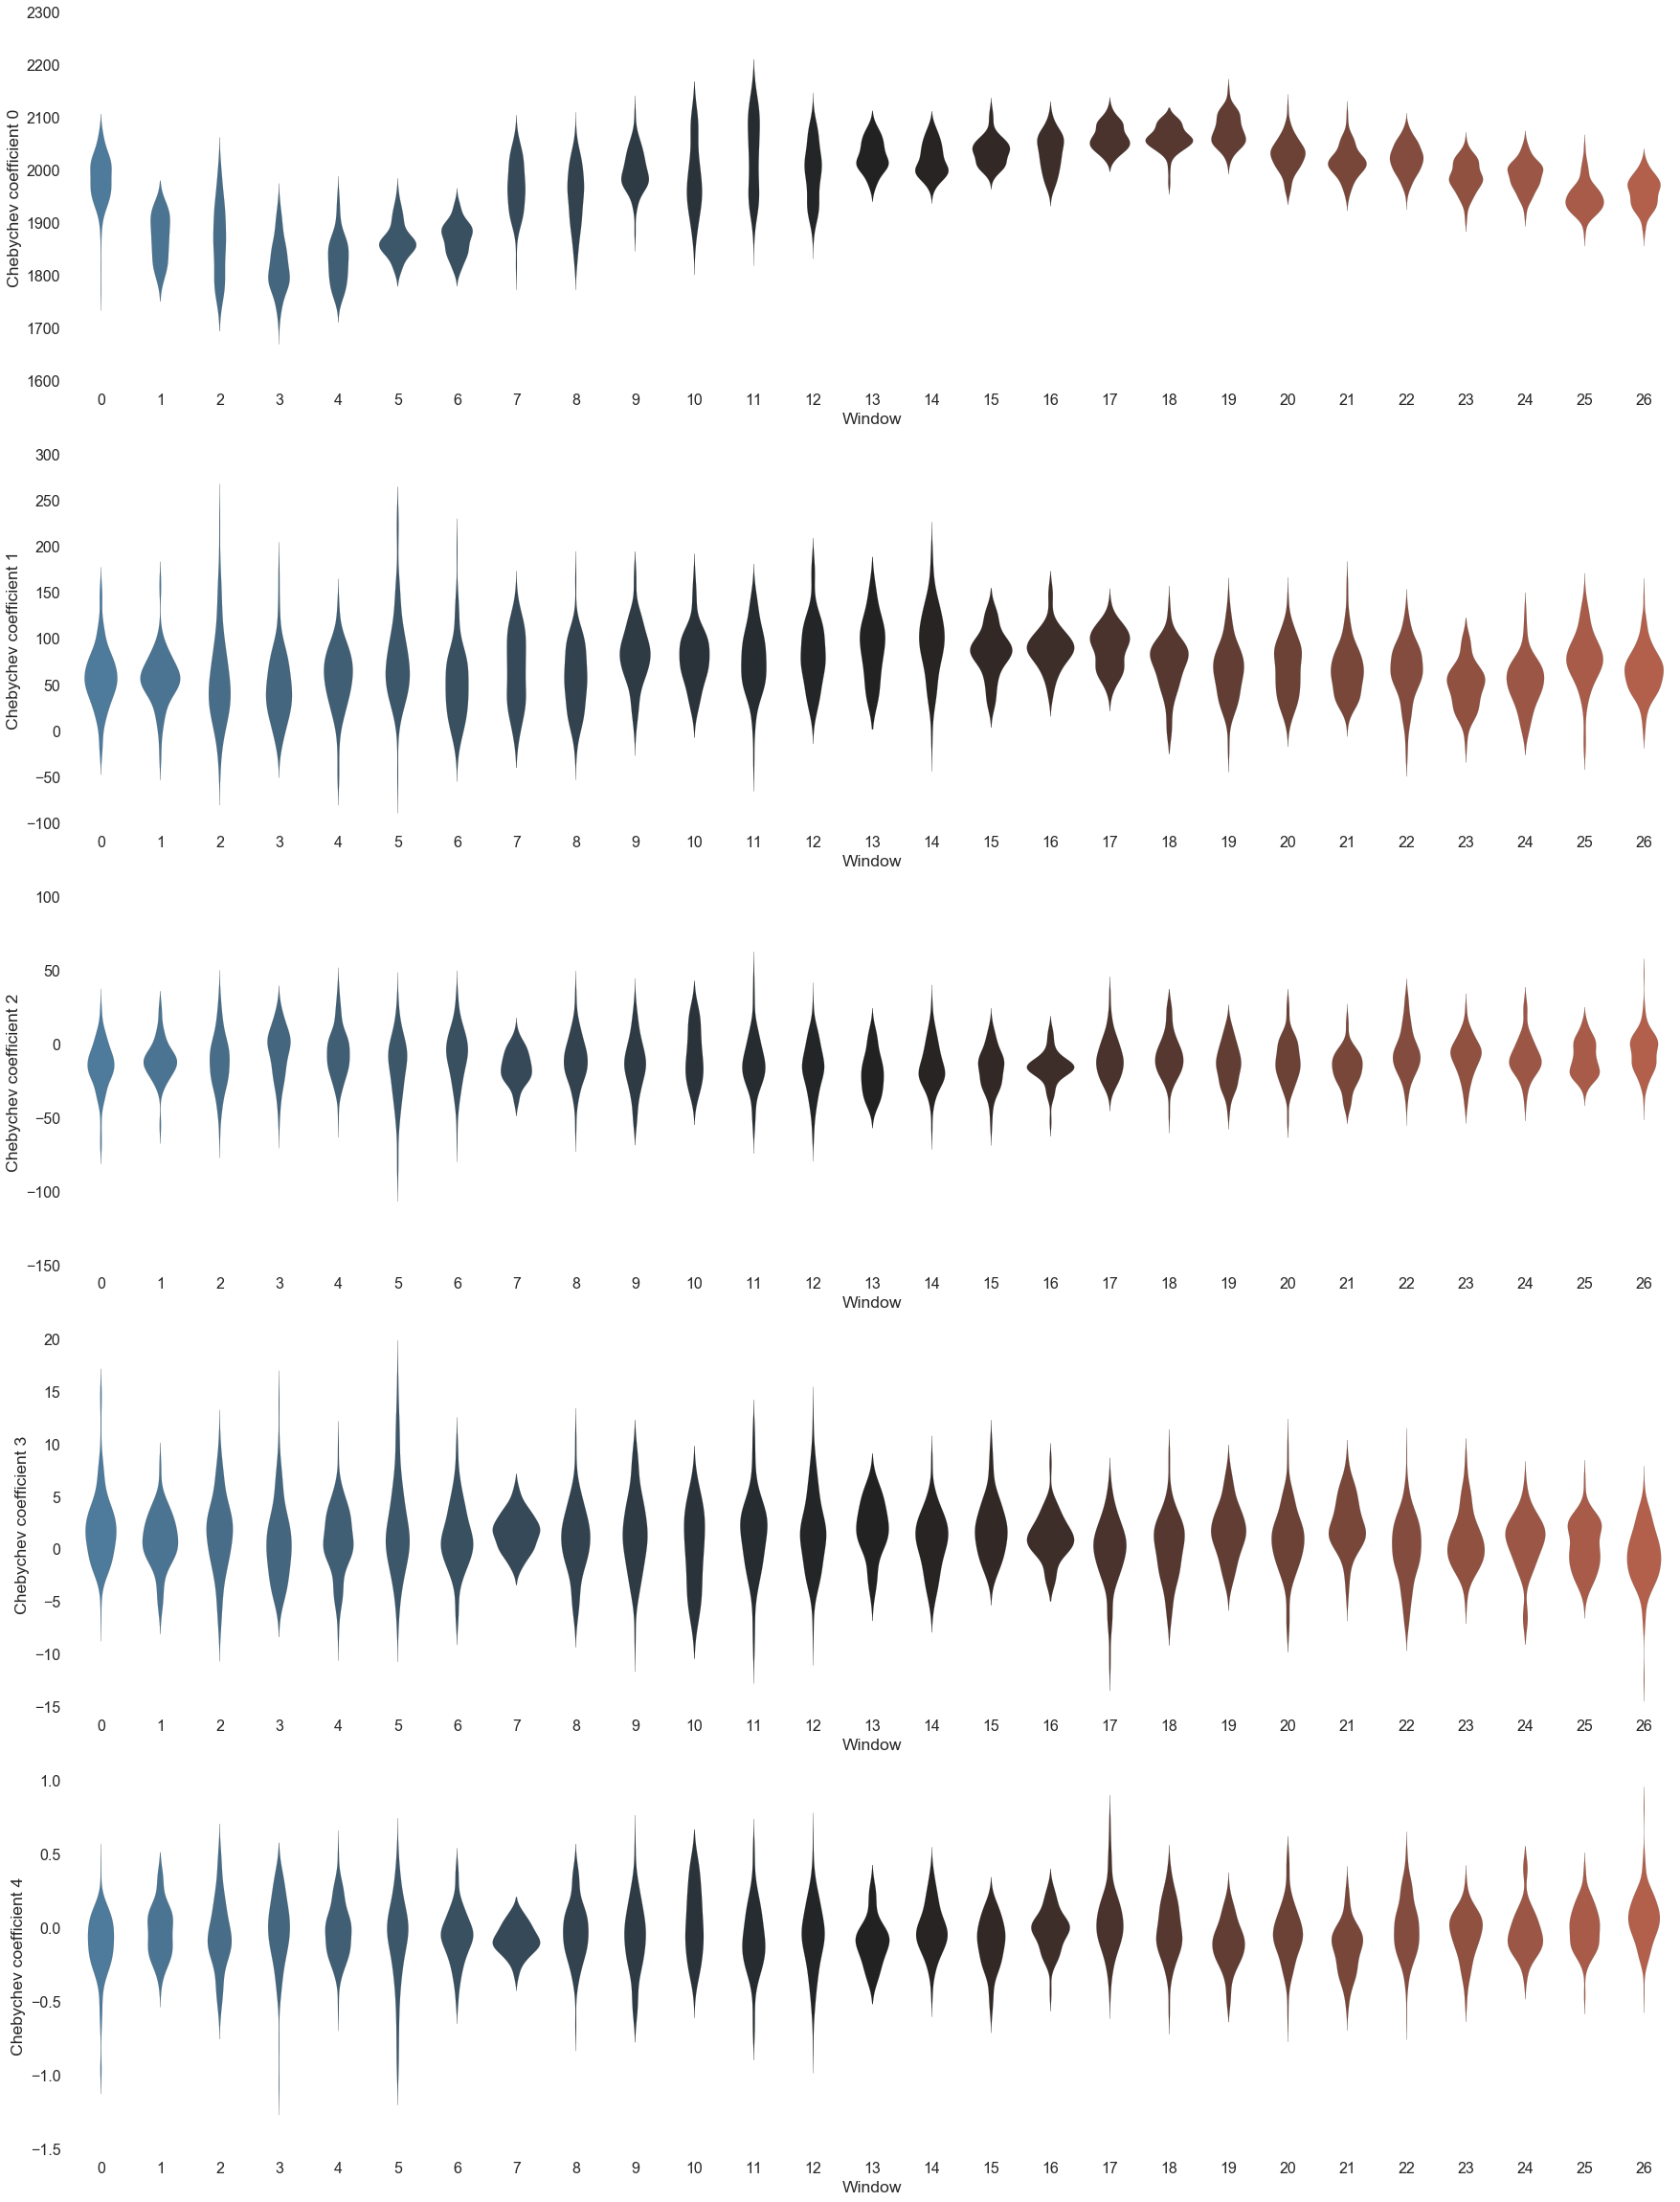

In [41]:
sns.set_context('poster')

fig = plt.figure(figsize=(30,40))

fig.add_subplot(511)
no_coeff = 0
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=eta_cmap[1:], 
                    inner=None, linewidth=0.1)


fig.add_subplot(512)
no_coeff = 1
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=eta_cmap[1:], 
                    inner=None, linewidth=0.1)


fig.add_subplot(513)
no_coeff = 2
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=eta_cmap[1:], 
                    inner=None, linewidth=0.1)



fig.add_subplot(514)
no_coeff = 3
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=eta_cmap[1:], 
                    inner=None, linewidth=0.1)




fig.add_subplot(515)
no_coeff = 4
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=eta_cmap[1:], 
                    inner=None, linewidth=0.1)

sns.despine(left=True, bottom=True)

#### Jensen shannon divergence between windows

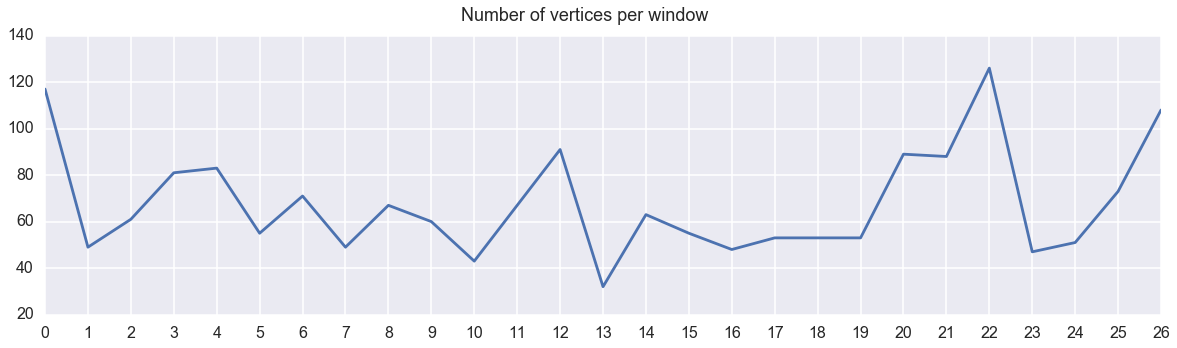

In [42]:
wsize=[]
for window in combined_windows:
    wsize.append(len(window))
sns.set_style('darkgrid')
fig = plt.figure(figsize=(20,5))
plt.plot(wsize)
plt.xlim([0, len(wsize)-1])
plt.xticks(np.arange(len(wsize)));
fig.suptitle('Number of vertices per window', fontsize=18)

In [43]:
five_colors = sns.color_palette('cubehelix',6)

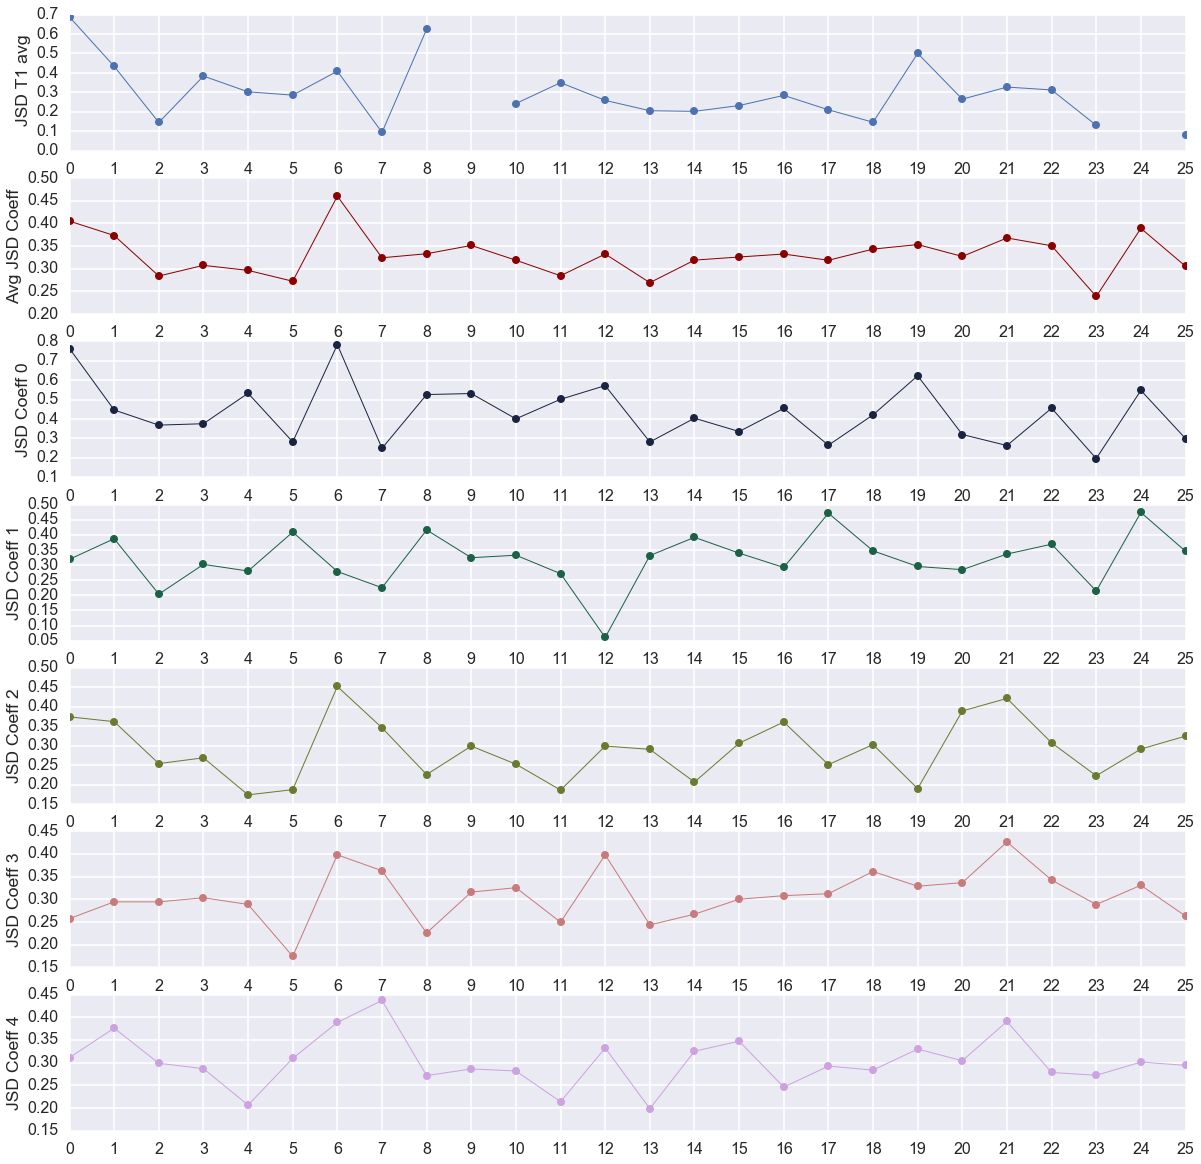

In [44]:
sns.set_context('poster')
fig = plt.figure(figsize=(20,20))

fig.add_subplot(711)
plt.plot(t1_avg_jsdis, marker='o', markersize=8,linewidth=1)
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.ylabel(' JSD T1 avg')


fig.add_subplot(712)
plt.plot(np.nanmean(cheb_jsdis, axis=1), marker='o', markersize=8,linewidth=1, color='darkred')
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.ylabel('Avg JSD Coeff')

for c in range(cheb_jsdis.shape[1]):
    fig.add_subplot(7,1,(c+3))
    plt.plot(cheb_jsdis[:,c], label=str(c), color=five_colors[c], marker='o', markersize=8, linewidth=1)
    plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
    plt.ylabel('JSD Coeff %i'%c)


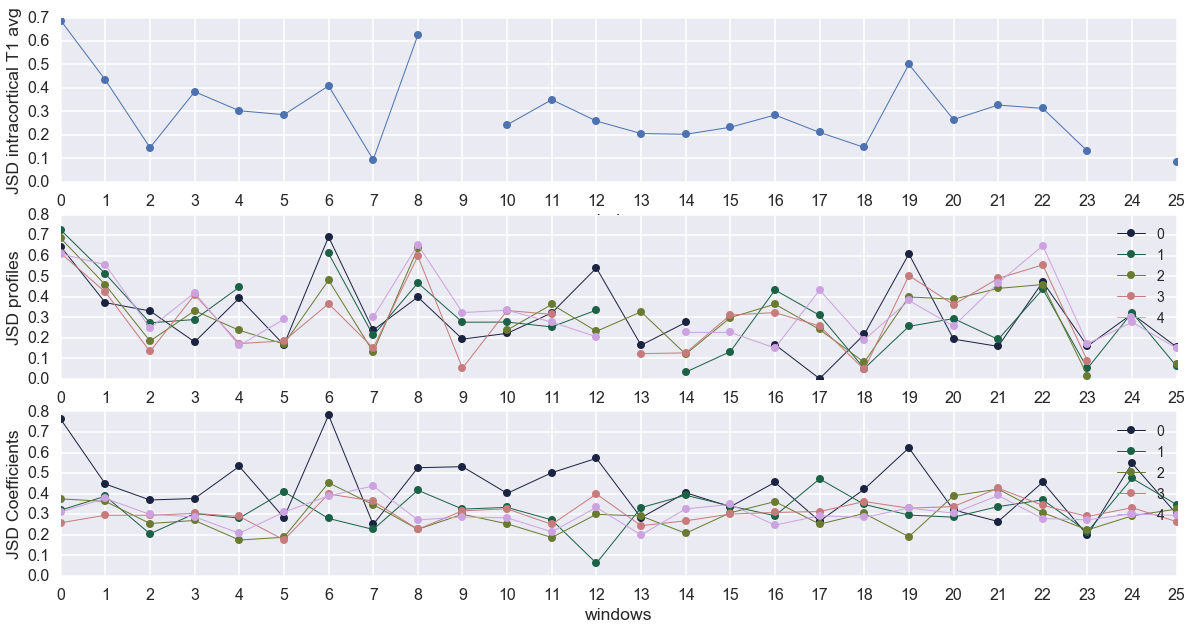

In [45]:
sns.set_context('poster')
fig = plt.figure(figsize=(20,10))

fig.add_subplot(311)
plt.plot(t1_avg_jsdis, marker='o', markersize=8,linewidth=1)
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.xlabel('windows')
plt.ylabel('JSD intracortical T1 avg')

fig.add_subplot(312)
for p in range(profile_jsdis.shape[1]):
    plt.plot(profile_jsdis[:,p], label=str(p), color=five_colors[p], marker='o', markersize=8, linewidth=1)
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.legend(fontsize=14)
plt.xlabel('windows')
plt.ylabel('JSD profiles')

fig.add_subplot(313)
for c in range(cheb_jsdis.shape[1]):
    plt.plot(cheb_jsdis[:,c], label=str(c), color=five_colors[c], marker='o', markersize=8, linewidth=1)
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.legend(fontsize=14)
plt.xlabel('windows')
plt.ylabel('JSD Coefficients')
